In [1]:
# NOTE: This notebook only works in Python 3
#       and uses the plydata package for
#       data manipulation.
import pandas as pd
import numpy as np

from plotnine import *
from plydata import *

### Ranges of Similar Variables

*Comparing the point to point difference of many similar variables*

Read the data.

Source: Pew Research Global Attitudes Spring 2015

In [2]:
data = pd.read_csv('data/survey-social-media.csv')
data = (
    data >>
    rename(country='COUNTRY',
           gender='Q145',
           age='Q146',
           use_internet='Q70',
           use_social_media='Q74') >>
    select('PSRAID', 'gender', 'use_internet', drop=True)
)

data >> sample_n(10, random_state=123)

,country,age,use_social_media
11376,Vietnam,48,Yes
12937,United States,51,Yes
19440,Pakistan,44,
30665,Malaysia,46,
37003,Israel,63,
19271,Pakistan,18,Yes
30445,Malaysia,40,Yes
16782,Poland,72,
39999,China,61,
8041,Kenya,35,Yes


Some helper functions

In [3]:
class build_query:
    
    @staticmethod
    def is_in(variable, iterable):
        """
        Build an 'is in' pandas query
        
        They are cumbersome to create, this method helps.
        
        Parameters
        ----------
        variable : str
            Variable
        iterable : iterable
            sequence in which to check


        >>> build_query.is_in('age', [50, 70, 90])
        '(age == 50)|(age == 70)|(age == 90)'
        """
        tokens = ('({} == {!r})'.format(variable, c) for c in iterable)
        return '|'.join(tokens)


def format_sequence(s, fmt='{}'):
    """
    Format items sequence
    
    Useful for creating labels from numeric data
    
    Parameters
    ----------
    s : sequence
        List of values
    
    Returns
    -------
    out : list
        List of string values
    """
    return [fmt.format(x) for x in s]

Create age groups for users of social media

In [4]:
def percent(gdf):
    return 100 * np.sum(gdf['use_social_media'] == 'Yes') / len(gdf)

def country_count(gdf):
    gdf['country_count'] = len(gdf)
    return gdf

rdata = (
    data
    >> define(age_group='"50+"')
    >> modify_where('age < "50"', age_group='"35-49"')
    >> modify_where('age < "35"', age_group='"18-34"')
    >> modify_where(build_query.is_in('age', ['Refused', "Don't know"]), age_group='""')
    >> group_by('country')
    >> do(country_count)
    >> query(build_query.is_in('age_group', ['18-34', '35-49', '50+']))
    >> query(build_query.is_in('use_social_media', ['Yes', 'No']))
    >> group_by('country', 'age_group')
    >> do(
        percent=percent,
        response_rate=lambda gdf: len(gdf)/gdf['country_count'].iloc[0]
    )
)

rdata.head()

,country,age_group,percent,response_rate
0,Argentina,18-34,90.883191,0.351000
1,Argentina,35-49,84.403670,0.218000
2,Argentina,50+,67.333333,0.150000
3,Australia,18-34,90.862944,0.196215
4,Australia,35-49,78.048780,0.204183


Top 14 countries by response rate to the social media question.

In [5]:
n = 14

top = (
    rdata
    >> group_by('country')
    >> summarize(r='sum(response_rate)')
    >> arrange('-r')
    >> head(n)
)

point_data = (
    rdata
    >> query(build_query.is_in('country', top['country']))
)

point_data >> head(9)

,country,age_group,percent,response_rate
3,Australia,18-34,90.862944,0.196215
4,Australia,35-49,78.048780,0.204183
5,Australia,50+,48.479087,0.523904
12,Canada,18-34,92.063492,0.250996
13,Canada,35-49,75.925926,0.215139
14,Canada,50+,53.986333,0.437251
15,Chile,18-34,95.569620,0.316000
16,Chile,35-49,84.810127,0.237000
17,Chile,50+,57.396450,0.169000


In [6]:
segment_data = (
    point_data
    >> group_by('country')
    >> summarise(min='min(percent)', max='max(percent)')
    >> define(gap='max-min')
    >> arrange('-gap')                                  #
)

segment_data >> head()

,country,max,min,gap
3,France,84.824903,30.564784,54.260119
4,Germany,79.646018,29.384966,50.261052
7,Japan,78.735632,30.794702,47.940930
0,Australia,90.862944,48.479087,42.383857
9,South Korea,75.147929,33.532934,41.614995


Format the floating point data that will be plotted into strings

In [7]:
point_data >>= define(
    percent_str='format_sequence(percent, "{:.0f}")'
)

point_data >>= modify_where('country == "France"', percent_str='percent_str+"%"')

segment_data >>= define(
    min_str='format_sequence(min, "{:.0f}")',
    max_str='format_sequence(max, "{:.0f}")',
    gap_str='format_sequence(gap, "{:.0f}")',
)

segment_data >> head()

,country,max,min,gap,min_str,gap_str,max_str
3,France,84.824903,30.564784,54.260119,31,54,85
4,Germany,79.646018,29.384966,50.261052,29,50,80
7,Japan,78.735632,30.794702,47.940930,31,48,79
0,Australia,90.862944,48.479087,42.383857,48,42,91
9,South Korea,75.147929,33.532934,41.614995,34,42,75


Set the order of the countries along the y-axis by setting the `country` variable to an ordered categorical.

In [8]:
categories = list(segment_data['country'])[::-1]

segment_data >>= define(
    country='pd.Categorical(country, categories=categories, ordered=True)'
)

point_data >>= define(
    country='pd.Categorical(country, categories=categories, ordered=True)'
)

First plot

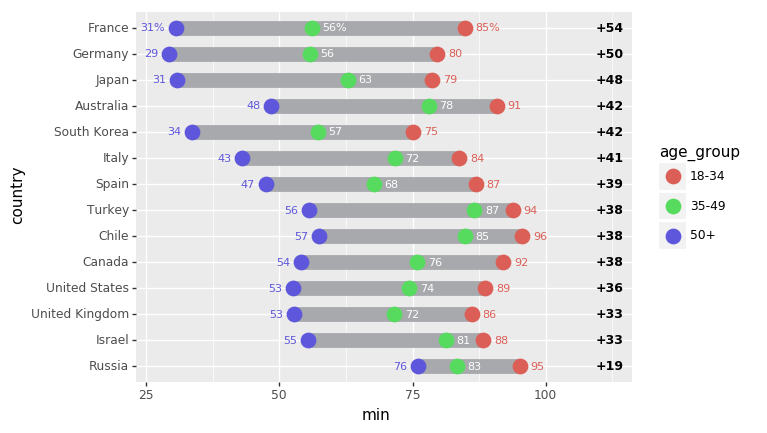

<ggplot: (97654321012345679)>

In [9]:
# The right column (youngest-oldest gap) location
xgap = 112

(ggplot()
 # Range strip
 + geom_segment(
     segment_data,
     aes(x='min', xend='max', y='country', yend='country'),
     size=6,
     color='#a7a9ac'
 )
 # Age group markers
 + geom_point(
     point_data,
     aes('percent', 'country', color='age_group', fill='age_group'),
     size=5,
     stroke=0.7,
 )
 # Age group percentages
 + geom_text(
     point_data >> query('age_group=="50+"'),
     aes(x='percent-2', y='country', label='percent_str', color='age_group'),
     size=8,
     ha='right',
 )
 + geom_text(
     point_data >> query('age_group=="35-49"'),
     aes(x='percent+2', y='country', label='percent_str'),
     size=8,
     ha='left',
     va='center',
     color='white'
 )
 + geom_text(
     point_data >> query('age_group=="18-34"'),
     aes(x='percent+2', y='country', label='percent_str', color='age_group'),
     size=8,
     ha='left',
 )
 # gap difference
 + geom_text(
     segment_data,
     aes(x=xgap, y='country', label='gap_str'),
     size=9,
     fontweight='bold',
     format_string='+{}'
 )
)

Tweak it

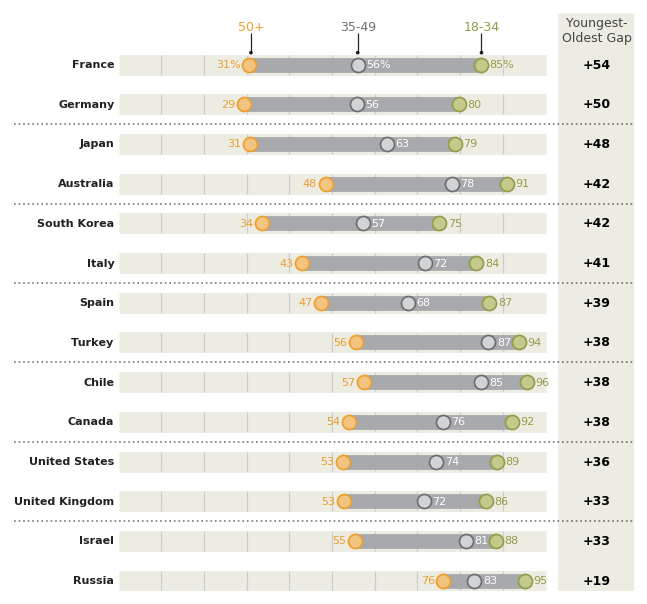

<ggplot: (97654321012345679)>

In [10]:
# The right column (youngest-oldest gap) location
xgap = 112

(ggplot()
 # Background Strips                                     # new
 + geom_segment(
     segment_data,
     aes(y='country', yend='country'),
     x=0, xend=100,
     size=8.5,
     color='#edece3'
 )
 # vertical grid lines along the strips                  # new
 + annotate(
     'segment',
     x=list(range(10, 100, 10)) * n,
     xend=list(range(10, 100, 10)) * n,
     y=np.tile(np.arange(1, n+1), 9)-.25,
     yend=np.tile(np.arange(1, n+1), 9) + .25,
     color='#CCCCCC'
 )
 # Range strip
 + geom_segment(
     segment_data,
     aes(x='min', xend='max', y='country', yend='country'),
     size=6,
     color='#a7a9ac'
 )
 # Age group markers
 + geom_point(
     point_data,
     aes('percent', 'country', color='age_group', fill='age_group'),
     size=5,
     stroke=0.7,
 )
 # Age group percentages
 + geom_text(
     point_data >> query('age_group=="50+"'),
     aes(x='percent-2', y='country', label='percent_str', color='age_group'),
     size=8,
     ha='right',
 )
 + geom_text(
     point_data >> query('age_group=="35-49"'),
     aes(x='percent+2', y='country', label='percent_str'),
     size=8,
     ha='left',
     va='center',
     color='white'
 )
 + geom_text(
     point_data >> query('age_group=="18-34"'),
     aes(x='percent+2', y='country', label='percent_str', color='age_group'),
     size=8,
     ha='left',
 )
 # countries right-hand-size (instead of y-axis)         # new
 + geom_text(
     segment_data,
     aes(y='country', label='country'),
     x=-1,
     size=8,
     ha='right',
     fontweight='bold',
     color='#222222'
 )
 # gap difference
 + geom_vline(xintercept=xgap, color='#edece3', size=32)  # new
 + geom_text(
     segment_data,
     aes(x=xgap, y='country', label='gap_str'),
     size=9,
     fontweight='bold',
     format_string='+{}'
 )
 # Annotations                                            # new
 + annotate('text', x=31, y=n+1.1, label='50+', size=9, color='#ea9f2f', va='top')
 + annotate('text', x=56, y=n+1.1, label='35-49', size=9, color='#6d6e71', va='top')
 + annotate('text', x=85, y=n+1.1, label='18-34', size=9, color='#939c49', va='top')
 + annotate('text', x=xgap, y=n+.5, label='Youngest-\nOldest Gap', size=9, color='#444444', va='bottom', ha='center')
 + annotate('point', x=[31, 56, 85], y=n+.3, alpha=0.85, stroke=0)
 + annotate('segment', x=[31, 56, 85], xend=[31, 56, 85], y=n+.3, yend=n+.8, alpha=0.85)
 + annotate('hline', yintercept=[x+0.5 for x in range(2, n, 2)], alpha=.5, linetype='dotted', size=0.7)
 
 # Better spacing and color                              # new
 + scale_x_continuous(limits=(-18, xgap+2))
 + scale_y_discrete(expand=(0, 0, 0.1, 0))
 + scale_fill_manual(values=['#c3ca8c', '#d1d3d4', '#f2c480'])
 + scale_color_manual(values=['#939c49', '#6d6e71', '#ea9f2f'])
 + guides(color=None, fill=None)
 + theme_void()
 + theme(figure_size=(8, 7.5))
)

Instead of looking at this plot as having a country variable on the `y-axis` and a percentage variable on the `x-axis`,
we can view it as having vertically stacked up many *indepedent* variables, the values of which have a similar scale.

**Protip:** Save a pdf file.

### Change in Rank

*Comparing a group of ranked items at two different times*

Read the data.

Source: World Bank - Infanct Mortality Rate (per 1,000 live births)b

In [11]:
data = pd.read_csv(
    'data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv',
    skiprows=[0, 1, 2])

# Columns as valid python variables
year_columns = {'y{}'.format(c): c for c in data.columns if c[:2] in {'19', '20'}}

data = (
    data    
    >> rename({'country': 'Country Name', 'code': 'Country Code'})
    >> rename(year_columns)
    >> select('Indicator Name', 'Indicator Code', 'Unnamed: 61', drop=True)
)

data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,240.5,236.3,232.3,228.5,224.6,220.7,217.0,...,80.4,78.6,76.8,75.1,73.4,71.7,69.9,68.1,66.3,NaN
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,117.1,114.7,112.2,109.6,106.8,104.1,101.4,98.8,96.0,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.7,16.0,15.4,14.8,14.3,13.8,13.3,12.9,12.5,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.1,NaN


The data includes regional aggregates. To tell apart the regional aggregates we need the metadata.
Every row in the data table has a corresponding row in the metadata table. Where the row has
regional aggregate data, the `Region` column in the metadata table is `NaN`.

In [12]:
metadata = pd.read_csv(
    'data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/Metadata_Country_API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv'
)

metadata = (
    metadata
    >> rename({'code': 'Country Code',
               'region': 'Region',
               'income_group': 'IncomeGroup'
               })
    >> select('code', 'region', 'income_group')
)

cat_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
metadata['income_group'] = pd.Categorical(metadata['income_group'], categories=cat_order, ordered=True)

metadata >> head(10)

,code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income
5,ARB,NaN,NaN
6,ARE,Middle East & North Africa,High income
7,ARG,Latin America & Caribbean,Upper middle income
8,ARM,Europe & Central Asia,Lower middle income
9,ASM,East Asia & Pacific,Upper middle income


`ARB` (row 5) is a regional code.

Drop the regional aggregates from the metadata

In [13]:
# Drop the aggregates from
country_metadata = metadata >> dropna(subset=['region'])
country_metadata >> head(10)

,code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income
6,ARE,Middle East & North Africa,High income
7,ARG,Latin America & Caribbean,Upper middle income
8,ARM,Europe & Central Asia,Lower middle income
9,ASM,East Asia & Pacific,Upper middle income
10,ATG,Latin America & Caribbean,High income


Remove the regional aggregates, to create a table with only country data

In [14]:
country_data = inner_join(data, country_metadata, on='code')
country_data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,region,income_group
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America & Caribbean,High income
1,Afghanistan,AFG,NaN,240.5,236.3,232.3,228.5,224.6,220.7,217.0,...,76.8,75.1,73.4,71.7,69.9,68.1,66.3,NaN,South Asia,Low income
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.2,109.6,106.8,104.1,101.4,98.8,96.0,NaN,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.4,14.8,14.3,13.8,13.3,12.9,12.5,NaN,Europe & Central Asia,Upper middle income
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.6,2.5,2.4,2.3,2.2,2.1,2.1,NaN,Europe & Central Asia,High income


We are interested in the changes in rank between 1960 and 2015. To plot a reasonable sized graph, we randomly
sample 35 countries.

In [15]:
sampled_data = (
    country_data
    >> dropna(subset=['y1960', 'y2015'])
    >> sample_n(35, random_state=123)
    >> define(
        y1960_rank='y1960.rank(method="min").astype(int)',
        y2015_rank='y2015.rank(method="min").astype(int)'
    )
)

sampled_data >> head()

,country,code,y1960,y1961,y1962,y1963,y1964,y1965,y1966,y1967,...,y2011,y2012,y2013,y2014,y2015,y2016,region,income_group,y2015_rank,y1960_rank
25,Bolivia,BOL,173.4,170.5,167.7,165.0,162.2,159.4,156.5,153.6,...,35.3,34.0,32.8,31.7,30.6,NaN,Latin America & Caribbean,Lower middle income,26,33
182,Sweden,SWE,16.3,16.0,15.6,15.0,14.4,13.7,13.0,12.6,...,2.4,2.4,2.4,2.4,2.4,NaN,Europe & Central Asia,High income,1,1
106,Kuwait,KWT,101.6,95.2,89.0,83.3,77.8,72.6,68.0,63.7,...,8.9,8.5,8.1,7.7,7.3,NaN,Middle East & North Africa,High income,10,15
63,Fiji,FJI,54.0,52.1,50.3,48.8,47.5,46.3,45.3,44.5,...,20.1,20.0,19.7,19.4,19.1,NaN,East Asia & Pacific,Upper middle income,21,8
160,Paraguay,PRY,62.6,62.0,61.4,60.9,60.5,60.0,59.6,59.3,...,19.8,19.2,18.6,18.1,17.5,NaN,Latin America & Caribbean,Upper middle income,17,11


First graph

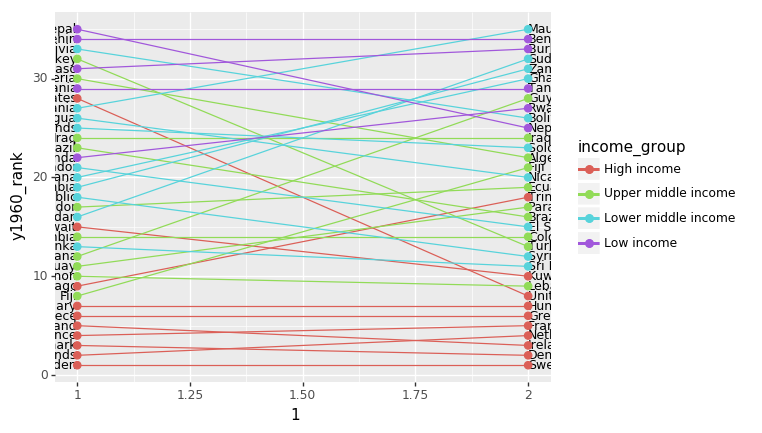

<ggplot: (97654321012345679)>

In [16]:
(ggplot(sampled_data)
 + geom_text(aes(1, 'y1960_rank', label='country'), ha='right', size=9)
 + geom_text(aes(2, 'y2015_rank', label='country'), ha='left', size=9)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5)
 + geom_point(aes(2, 'y2015_rank', color='income_group'), size=2.5)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2015_rank', color='income_group'))
)

It has the form we want, but we need to tweak it.

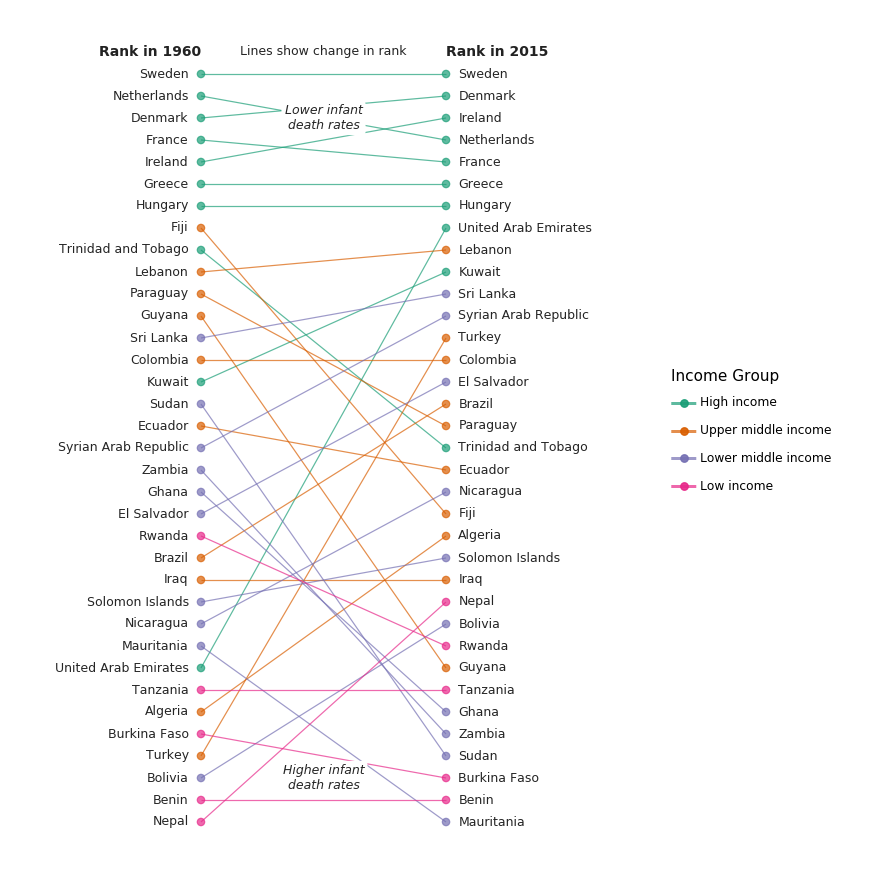

<ggplot: (97654321012345679)>

In [17]:
# Text colors
black1 = '#252525'
black2 = '#222222'

(ggplot(sampled_data)
 # Slight modifications for the original lines,
 # 1. Nudge the text to either sides of the points
 # 2. Alter the color and alpha values
 + geom_text(aes(1, 'y1960_rank', label='country'), nudge_x=-0.05, ha='right', size=9, color=black1)
 + geom_text(aes(2, 'y2015_rank', label='country'), nudge_x=0.05, ha='left', size=9, color=black1)
 + geom_point(aes(1, 'y1960_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_point(aes(2, 'y2015_rank', color='income_group'), size=2.5, alpha=.7)
 + geom_segment(aes(x=1, y='y1960_rank', xend=2, yend='y2015_rank', color='income_group'), alpha=.7)
 
 # Text Annotations
 + annotate('text', x=1, y=0, label='Rank in 1960', fontweight='bold', ha='right', size=10, color=black2)
 + annotate('text', x=2, y=0, label='Rank in 2015', fontweight='bold', ha='left', size=10, color=black2)
 + annotate('text', x=1.5, y=0, label='Lines show change in rank', size=9, color=black1)
 + annotate('label', x=1.5, y=3, label='Lower infant\ndeath rates', size=9, color=black1,
            label_size=0, fontstyle='italic')
 + annotate('label', x=1.5, y=33, label='Higher infant\ndeath rates', size=9, color=black1,
            label_size=0, fontstyle='italic')
 
 # Prevent country names from being chopped off
 + lims(x=(0.35, 2.65))
 + labs(color='Income Group')
 # Countries with lower rates on top
 + scale_y_reverse()
 # Change colors
 + scale_color_brewer(type='qual', palette=2)
 # Removes all decorations
 + theme_void()
 # Changing the figure size prevents the country names from squishing up
 + theme(figure_size=(8, 11))
)